In [1]:
import tensorflow as tf
import numpy as np
import altair as alt
import pandas as pd
import matplotlib.pyplot as plt
from get_network import get_model, normalize
from regularized_explanations import ops
from tqdm import tqdm
import scipy.misc

In [2]:
def norm_clip(x):
    normalized = normalize(x.squeeze())
    clipped = np.clip(normalized, a_min=np.min(normalized), a_max=np.percentile(normalized, 99.9))
    return clipped

In [3]:
explainer = ops.TFOpsExplainer

In [4]:
model, sess = get_model()

In [5]:
image_op    = model.image_op
images_pl   = model.images_pl
labels_pl   = model.labels_pl
label_op    = model.label_op
logits      = model.logits
pred_labels = model.pred_labels
delta_pl = tf.placeholder(tf.float32, [None, 299, 299, 3])

In [6]:
grad_op = explainer._grad_across_multi_output(explainer, output_tensor=logits, input_tensor=images_pl, sparse_labels_op=labels_pl)
grad_input_op = grad_op * delta_pl

In [7]:
alpha_range = np.linspace(0.0, 1.0, num=51)

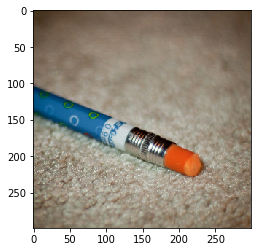

In [8]:
images = np.load('data/images.npy')
labels = np.load('data/labels.npy')
image_input = images[1]
label_input = labels[1]

image_input = np.expand_dims(image_input, axis=0)
label_input = np.expand_dims(label_input, axis=0)
plt.imshow(normalize(image_input[0]))

In [9]:
reference = np.zeros([1, 299, 299, 3]) - 1.0
ig_weights_acc = []
interp_inputs_acc = []
for alpha in tqdm(alpha_range):
    interp_input = alpha * image_input + (1.0 - alpha) * reference
    interp_input = np.clip(interp_input, a_min=-1.0, a_max=1.0)
    ig_sample = sess.run(grad_input_op, feed_dict = {images_pl: interp_input, 
                                                     labels_pl: label_input,
                                                     delta_pl:  image_input - reference})
    ig_sample = ig_sample.sum(axis=-1)
    ig_sample = np.abs(ig_sample)
    ig_weights_acc.append(ig_sample)
    interp_inputs_acc.append(interp_input)

100%|██████████| 51/51 [00:06<00:00, 13.20it/s]


In [10]:
ig_weights_acc = np.array(ig_weights_acc).squeeze()
interp_inputs_acc = np.array(interp_inputs_acc).squeeze()

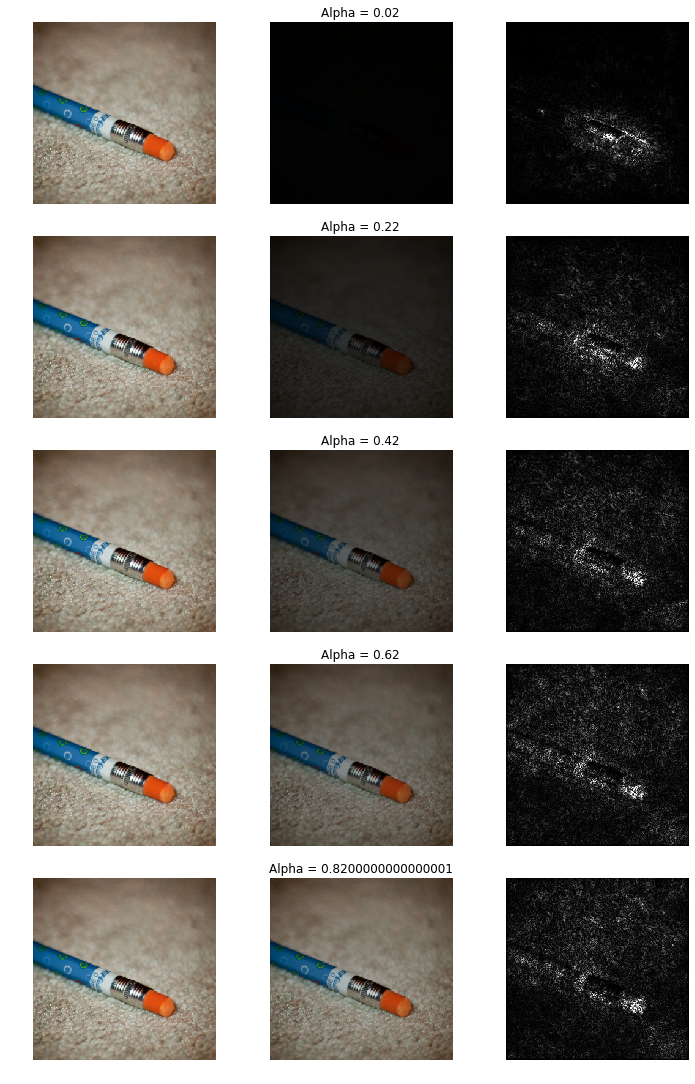

In [11]:
fig, axs = plt.subplots(5, 3, figsize=(10, 15))
fig.tight_layout()
im_domain =  [-1.0, 1.0]
im_range = [0.0, 1.0]
for i in range(5):
    axs[i, 0].imshow(normalize(image_input[0], _range=im_range, _domain=im_domain))
    axs[i, 1].imshow(normalize(interp_inputs_acc[1 + 10 * i], _range=im_range, _domain=im_domain), cmap='gray')
    axs[i, 1].set_title('Alpha = {}'.format(alpha_range[1 + 10 * i]))
    axs[i, 2].imshow(norm_clip(ig_weights_acc[1 + 10 * i]), cmap='gray')
    
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
    axs[i, 2].axis('off')

In [12]:
ig_weights = np.mean(ig_weights_acc, axis=0)

(-0.5, 298.5, 298.5, -0.5)

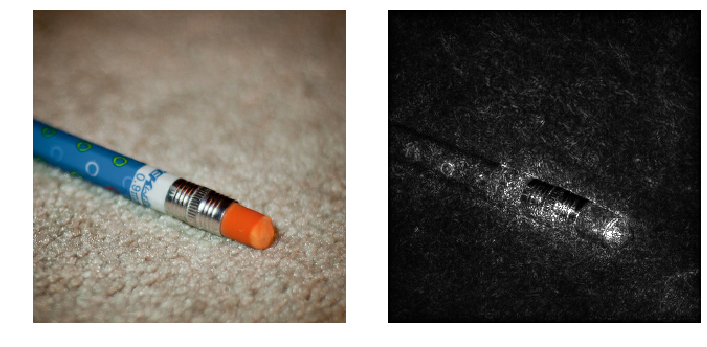

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout()
im_domain =  [-1.0, 1.0]
im_range = [0.0, 1.0]

axs[0].imshow(normalize(image_input[0], _range=im_range, _domain=im_domain))
axs[1].imshow(norm_clip(ig_weights), cmap='gray')

axs[0].axis('off')
axs[1].axis('off')

In [14]:
for i in tqdm(range(len(alpha_range))):
    alpha = alpha_range[i]
    alpha = int(alpha * 100) / 100.0
    weights = ig_weights_acc[i]
    im_weights = norm_clip(weights)
    interp  = interp_inputs_acc[i]
    scipy.misc.toimage(im_weights).save('data/ig_weights_acc/weights_alpha{}.png'.format(alpha))
    scipy.misc.toimage(interp, cmin=-1.0, cmax=1.0).save('data/ig_weights_acc/interp_alpha{}.png'.format(alpha))

  0%|          | 0/51 [00:00<?, ?it/s]/home/psturm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  import sys
/home/psturm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  
100%|██████████| 51/51 [00:02<00:00, 23.21it/s]


In [15]:
ig_weights_cu = np.cumsum(ig_weights_acc, axis=0)

divisor = np.arange(ig_weights_cu.shape[0]) + 1
divisor = divisor[:, np.newaxis, np.newaxis]

ig_weights_cu = ig_weights_cu / divisor

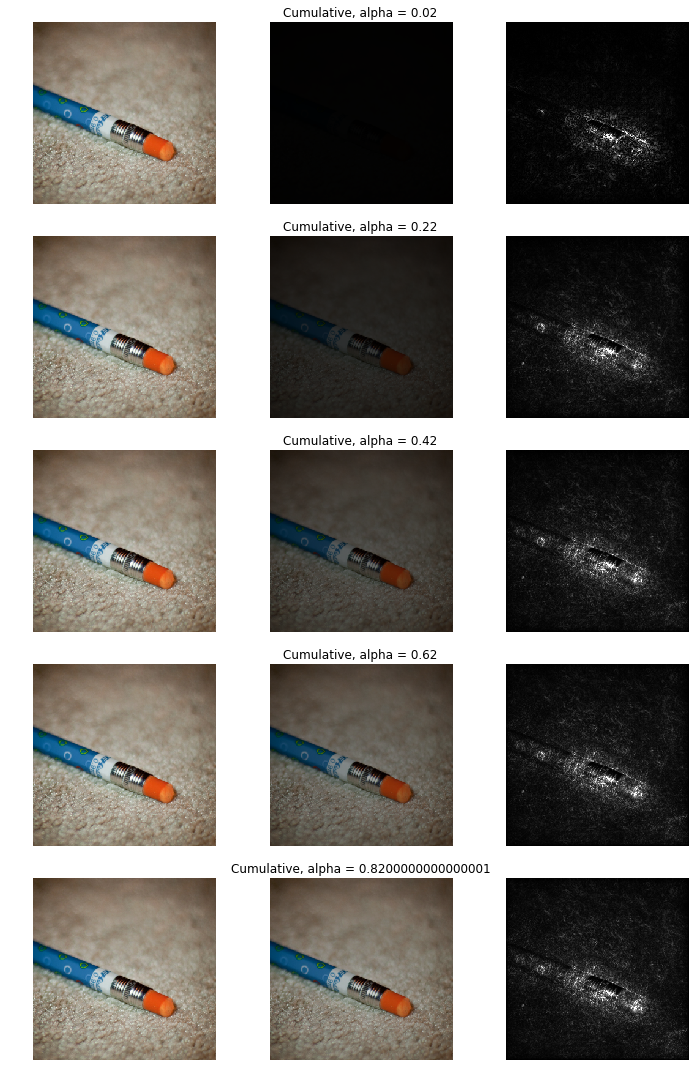

In [16]:
fig, axs = plt.subplots(5, 3, figsize=(10, 15))
fig.tight_layout()
im_domain =  [-1.0, 1.0]
im_range = [0.0, 1.0]
for i in range(5):
    axs[i, 0].imshow(normalize(image_input[0], _range=im_range, _domain=im_domain))
    axs[i, 1].imshow(normalize(interp_inputs_acc[1 + 10 * i], _range=im_range, _domain=im_domain), cmap='gray')
    axs[i, 1].set_title('Cumulative, alpha = {}'.format(alpha_range[1 + 10 * i]))
    axs[i, 2].imshow(norm_clip(ig_weights_cu[1 + 10 * i]), cmap='gray')
    
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
    axs[i, 2].axis('off')

In [17]:
for i in tqdm(range(len(alpha_range))):
    alpha = alpha_range[i]
    alpha = int(alpha * 100) / 100.0
    weights = ig_weights_cu[i]
    im_weights = norm_clip(weights)
    scipy.misc.toimage(im_weights).save('data/ig_weights_cu/weights_alpha{}.png'.format(alpha))

  0%|          | 0/51 [00:00<?, ?it/s]/home/psturm/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  
100%|██████████| 51/51 [00:00<00:00, 129.32it/s]


In [18]:
logit_out = sess.run(logits, feed_dict={images_pl: image_input})
baseline_logit_out = sess.run(logits, feed_dict={images_pl: reference})

In [19]:
output_val = logit_out[0, label_input[0]]
baseline_output_val = baseline_logit_out[0, label_input[0]]
target_sum = output_val - baseline_output_val

In [20]:
raw_weights_acc = []
interp_inputs_acc = []
reference = np.zeros([1, 299, 299, 3]) - 1.0
alpha_range = np.linspace(0.0, 1.0, num=51)
alpha_range = (alpha_range * 100).astype(np.int64) / 100.0

for alpha in tqdm(alpha_range):
    interp_input = alpha * image_input + (1.0 - alpha) * reference
    interp_input = np.clip(interp_input, a_min=-1.0, a_max=1.0)
    ig_sample = sess.run(grad_input_op, feed_dict = {images_pl: interp_input, 
                                                     labels_pl: label_input,
                                                     delta_pl:  image_input - reference})
    
    raw_weights_acc.append(ig_sample)
    interp_inputs_acc.append(interp_input)

100%|██████████| 51/51 [00:03<00:00, 13.89it/s]


In [21]:
interp_inputs_acc = np.array(interp_inputs_acc).squeeze()
raw_weights_acc = np.array(raw_weights_acc).squeeze()
raw_ig = np.mean(raw_weights_acc, axis=0)
raw_weights_acc_sum = np.sum(raw_weights_acc, axis=(1,2,3))

In [22]:
raw_weights_cu = np.cumsum(raw_weights_acc, axis=0)
divisor = np.arange(raw_weights_cu.shape[0]) + 1
divisor = divisor[:, np.newaxis, np.newaxis, np.newaxis]
raw_weights_cu = raw_weights_cu / divisor
raw_weights_sum = np.sum(raw_weights_cu, axis=(1,2,3))

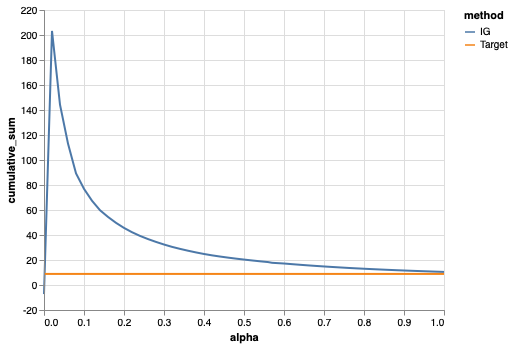

In [23]:
data = pd.DataFrame({
    'cumulative_sum': list(raw_weights_sum) + [target_sum] * len(alpha_range),
    'alpha': list(alpha_range) * 2,
    'method': ['IG'] * len(alpha_range) + ['Target'] * len(alpha_range)
})
alt.Chart(data).mark_line().encode(
    alt.X('alpha:Q'),
    alt.Y('cumulative_sum:Q'),
    alt.Color('method:N')
)

In [24]:
data.to_csv('data/alpha_cu_sum.csv', index=False)